In [7]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np

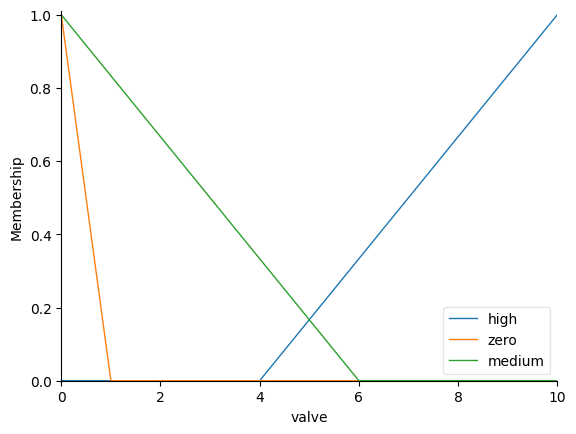

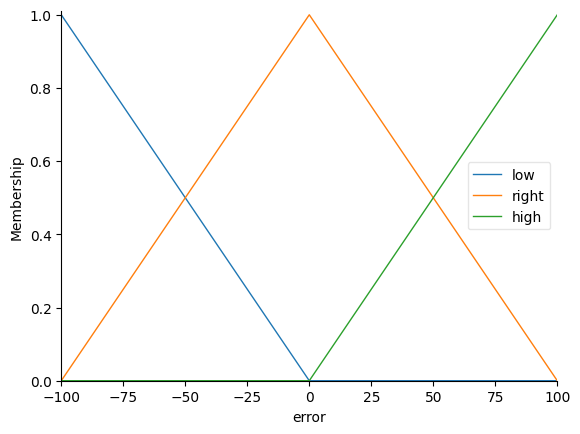

In [8]:
error = ctrl.Antecedent(np.arange(-100, 101, 1), 'error')
valve = ctrl.Consequent(np.arange(0, 11, 1), 'valve')

error['low'] = fuzz.trimf(error.universe, [-100, -100, 0])
error['right'] = fuzz.trimf(error.universe, [-100, 0, 100])  
error['high'] = fuzz.trimf(error.universe, [0, 100, 100])   

valve['high'] = fuzz.trimf(valve.universe, [4, 10, 10])
valve['zero'] = fuzz.trimf(valve.universe, [0, 0, 1])
valve['medium'] = fuzz.trimf(valve.universe, [0, 0, 6]) 

valve.view()
error.view()

## Rules

In [4]:
rule1 = ctrl.Rule(error['low'], valve['high'])

rule2 = ctrl.Rule(error['high'], valve['medium'])

rule3 = ctrl.Rule(error['right'], valve['zero'])

tank_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
tank_sim = ctrl.ControlSystemSimulation(tank_ctrl)

In [5]:
def call_tank_sim(error):
  global tank_sim

  tank_sim.input['error'] = error
  tank_sim.compute()
  return tank_sim.output['valve']

/tmp/ipykernel_12741/47659547.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i+1] = Level0
/tmp/ipykernel_12741/47659547.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i+1] = valve
/tmp/ipykernel_12741/47659547.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  es[i+1] = error


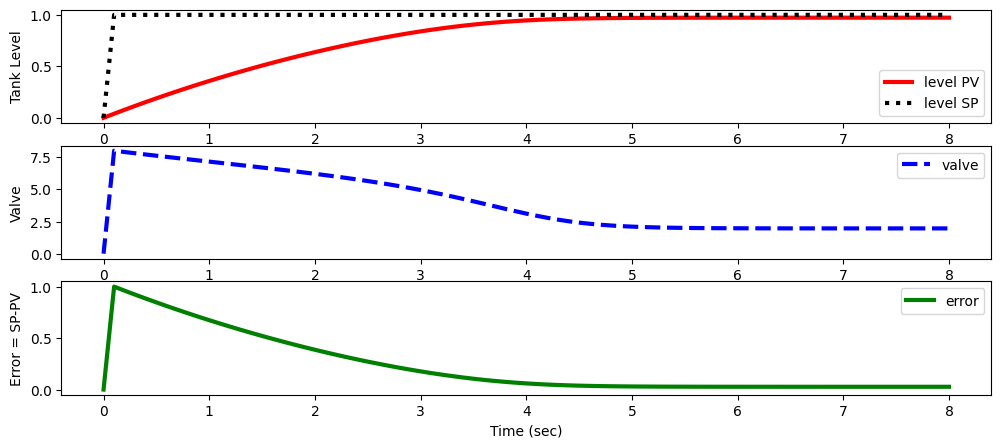

In [6]:
from IPython import display
import matplotlib.pyplot as plt
from scipy.integrate import odeint

animate=False
simulation_length = 80

def tank(Level,time,c,valve):
    rho = 1000.0 
    A = 1 
    dLevel_dt = (c/(rho*A)) * valve
    return dLevel_dt

ts = np.linspace(0,simulation_length//10, simulation_length + 1)

c = 50.0
u = np.zeros(simulation_length + 1)

Level0 = 0

valve = 10

outflow = 0.01

z = np.zeros(simulation_length + 1)
es = np.zeros(simulation_length + 1)
sps = np.zeros(simulation_length + 1)

SP = 1

plt.figure(1,figsize=(12,5))
if animate:
    plt.ion()
    plt.show()

for i in range(simulation_length):
    error = SP - Level0

    valve = call_tank_sim(-error * 100)

    u[i+1] = valve 
    es[i+1] = error 
    y = odeint(tank,Level0,[0,0.1],args=(c,valve))
    Level0 = y[-1] * (1.0 - outflow)
    z[i+1] = Level0
    sps[i+1] = SP

    if animate:
        # update plot
        display.clear_output(wait=True)
        plt.figure(1,figsize=(12,5))
        plt.subplot(3,1,1)
        plt.plot(ts[0:i+1],z[0:i+1],'r-',linewidth=3,label='level PV')
        plt.plot(ts[0:i+1],sps[0:i+1],'k:',linewidth=3,label='level SP')
        plt.ylabel('Tank Level')
        plt.legend(loc='best')
        plt.subplot(3,1,2)
        plt.plot(ts[0:i+1],u[0:i+1],'b--',linewidth=3,label='valve')
        plt.ylabel('Valve')    
        plt.legend(loc='best')
        plt.subplot(3,1,3)
        plt.plot(ts[0:i+1],es[0:i+1],'g-',linewidth=3,label='error')
        plt.ylabel('Error = SP-PV')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.pause(0.1)

if not animate:
    # plot results
    plt.subplot(3,1,1)
    plt.plot(ts,z,'r-',linewidth=3,label='level PV')
    plt.plot(ts,sps,'k:',linewidth=3,label='level SP')
    plt.ylabel('Tank Level')
    plt.legend(loc='best')
    plt.subplot(3,1,2)
    plt.plot(ts,u,'b--',linewidth=3,label='valve')
    plt.ylabel('Valve')    
    plt.legend(loc='best')
    plt.subplot(3,1,3)
    plt.plot(ts,es,'g-',linewidth=3,label='error')
    plt.ylabel('Error = SP-PV')    
    plt.xlabel('Time (sec)')
    plt.legend(loc='best')
    plt.show()